# Predicting Resolver Response Code Based on Query Headers and Zone Information

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import sklearn.preprocessing, sklearn.model_selection, sklearn.tree
import graphviz 

## Prepare Data

In [2]:
data = pd.read_pickle('ml_data.pickle')

In [3]:
features = list(filter(lambda c: c.startswith('feature_'), data.keys()))
labels = list(filter(lambda c: c.startswith('labels_'), data.keys()))
label = 'label_rcode'

### Display all Features that have *any* Variability

In [4]:
for c in features + labels:
    u = np.unique(data[c], return_counts=True)
    if len(u[0]) > 1:
        print(f"{c}: {len(u[0])} unique values")

feature_ip_ttl: 7 unique values
feature_ip_src: 45 unique values
feature_udp_len: 30 unique values
feature_dns_cd: 2 unique values
feature_zone_algorithm: 8 unique values
feature_zone_keysize: 7 unique values
feature_zone_nsec: 2 unique values


### Encode String-Based Features

In [5]:
ALGO_NAME = {
    5: b'rsasha1', 
    7: b'rsasha1nsec3sha1', 
    8: b'rsasha256', 
    10: b'rsasha512',
    13: b'ecdsap256sha256', 
    14: b'ecdsap384sha384', 
    15: b'ed25519', 
    16: b'ed448',
}
ALGO_NUM = {name: num for num, name in ALGO_NAME.items()}

In [6]:
data['feature_zone_algorithm'] = data.apply(lambda row: ALGO_NUM[row['feature_zone_algorithm']], axis=1)

In [7]:
le_feature_ip_src = sk.preprocessing.LabelEncoder()
le_feature_ip_src.fit(data['feature_ip_src'])
data['feature_ip_src'] = le_feature_ip_src.transform(data['feature_ip_src'])

### Define Training and Test Set

In [8]:
X = data[features]
Y = data[label]

In [9]:
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, train_size=0.5, random_state=1)

## Train and Evaluate Decision Tree

In [10]:
t = sk.tree.DecisionTreeClassifier()
t = t.fit(X_train, Y_train)

### Evaluate Prediction Error

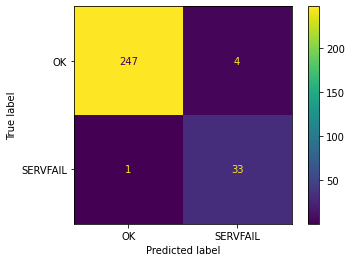

In [11]:
sklearn.metrics.plot_confusion_matrix(t, X_test, Y_test, display_labels=['OK', 'SERVFAIL'])

## Show Decision Tree

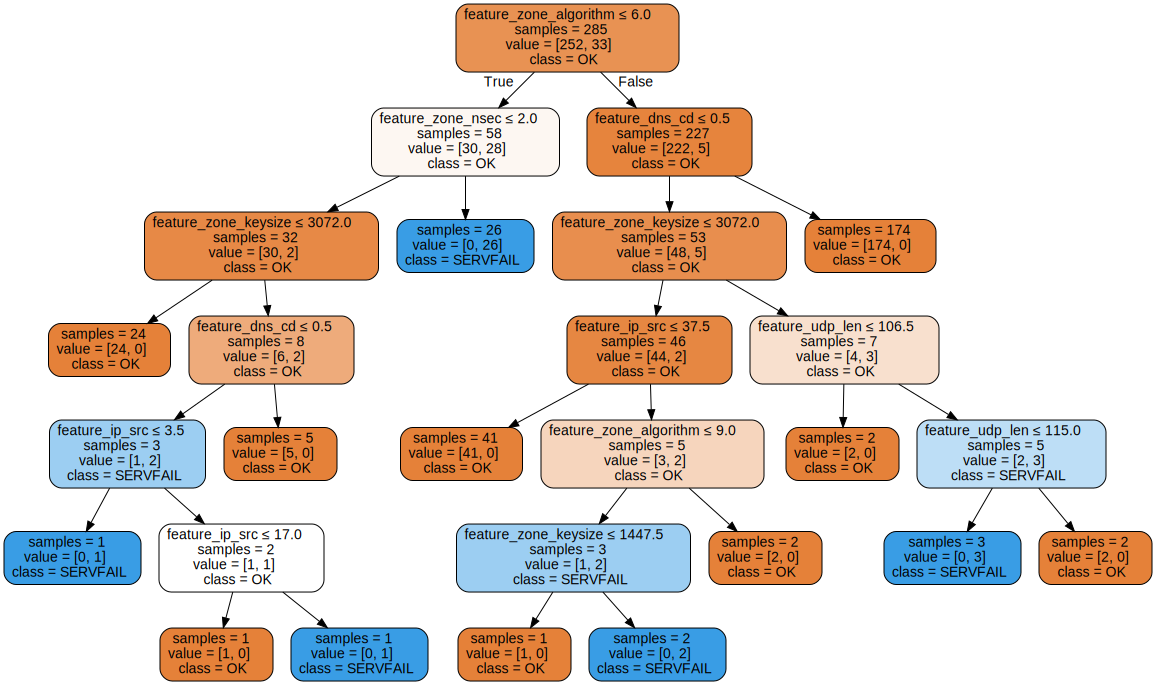

In [12]:
dot_data = sk.tree.export_graphviz(
    t, out_file=None, 
    feature_names=features,  
    class_names=['OK', 'SERVFAIL'],  
    filled=True, rounded=True,  
    special_characters=True,
    impurity=False,
)  
graph = graphviz.Source(dot_data)  
graph 